# Obligatorio de Analisis Predictivo de Series Temporales

## Análisis predictivo uso de slots en Big Query

### Estudiantes: 

Enrique Peirano - 252190  
Augusto Romero - 253261  
Mauricio Martinez - 134283  

In [1]:
#install.packages('Metrics')
library('astsa')
library(forecast)
library('Metrics')

options(repr.plot.width=14, repr.plot.height=6)


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas



Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




## Presentación de la serie de datos. Gráficas.

Para este trabajo usaremos la serie temporal del uso de slots de un proyecto de Big Query.
Big Query es un motor analítico de tipo SaaS que forma parte de las herramientas de Google Cloud Platform.
Se trata de un servicio serverless que permite a las organizaciones administrarlo y controlar sus costos en base a distintos modelos de pricing.  
El modelo que nos interesa analizar es el de los llamados "slots". En Big Query un "slot" es una unidad de procesamiento (similar a un cpu virtual).
Las consultas analíticas que se realizan sobre la plataforma son procesadas por slots y éstos son asignados por la plataforma de acuerdo a la demanda, la disponibilidad y la complejidad de las consultas.  
Nuestra serie de datos representa el uso de slots por intervalo de tiempo (medido en milisegundos de uso).
Ejemplo: si en un intervalo de un segundo se registra un uso de 1500ms de slots podemos decir que se usaron 1.5 slots.
Si bien esta es la unidad de medida original, para este trabajo decidimos realizar una modificación en el muestreo (los intervalos son de 5 minutos) y la unidad de medida es la cantidad de slots utilizados.


In [2]:
setwd('./')
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_resampled.csv")

In [3]:
ts_df <- ts_df[,2]

x = ts(ts_df, start=0 , frequency=1)


In [4]:
x = x/300000 # paso la unidad a slots

In [5]:
ts_df = ts_df/300000 # paso la unidad a slots

In [6]:
ts_df = ts(ts_df, start=0, frequency=1)

In [7]:
length(ts_df)

[1] 8928

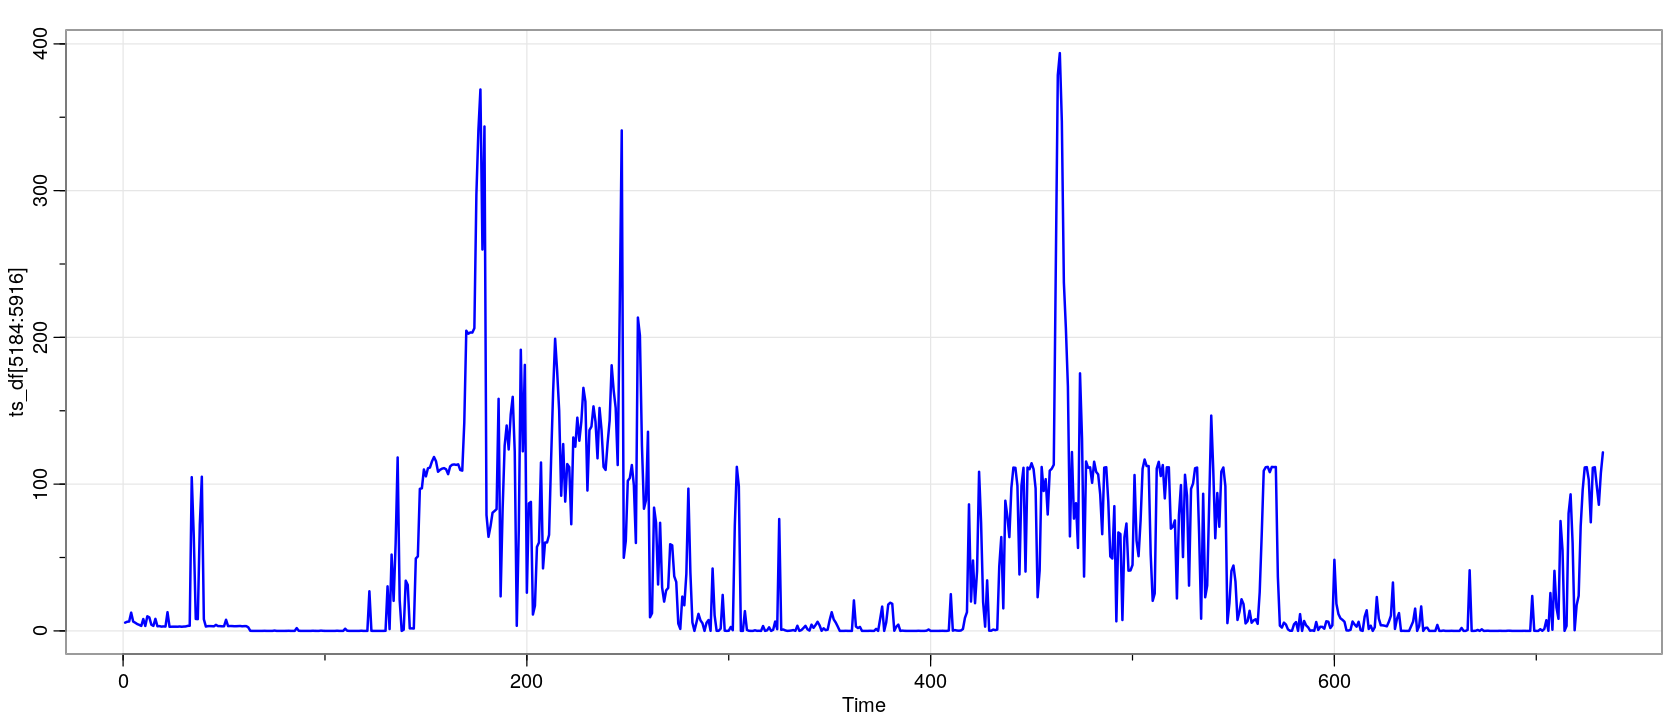

In [9]:
# dias 19 al 21 de mayo (arranca en 18*288=5184)
tsplot(ts_df[5184:5916], col=4, lwd=2)

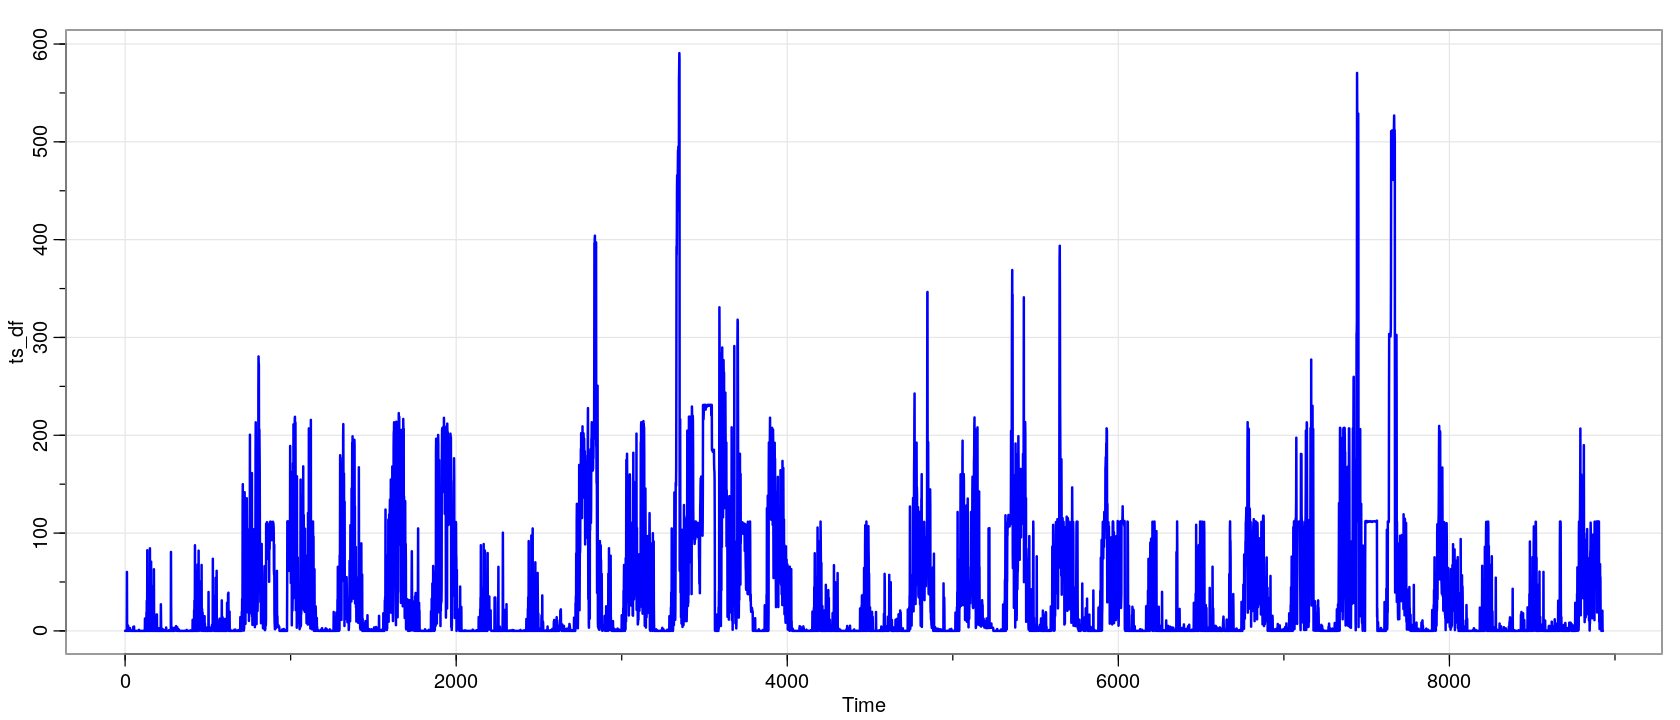

In [10]:
tsplot(ts_df, col=4, lwd=2)

In [11]:
# En esta función ajustamos el modelo ( utilizando los parámetros que fuimos optimizando durante el trabajo )
# y generamos una predicción 


train_predict <- function(start_train, start_test, time_series) {
    
    ret = c(0,0)
    
    ts_length = length(time_series)        
    
    end_train = start_test - 1

    ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
    ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)
    
    dn = ts_df_train
    dnt = ts_df_test
    
    # agrego para probar +1 para evitar log(0)
    ldn = log(dn+1)
    ldnt = log(dnt+1)
    t = time(ldn)
    
    fit = lm(ldn ~ t, na.action=NULL)
    
    ndata <- data.frame(t = start_test-1)
    
    predict_trend = predict(fit,newdata=ndata)
    
    predicttrend = ts(fitted(fit), start=start_train-1, freq=1)
    
    ldn = as.numeric(ldn)
    ldnc = ldn-predicttrend
      
    t = time(ldnc)

    f1 =  0.000192
    f2 =  0.000385
    f3 =  0.000578
    f4 =  0.000771
    f5 =  0.000964
    f6 =  0.001157
    f7 =  0.002507
    f8 =  0.002893
    f9 =  0.003472
    f10 = 0.004436
    f11 = 0.006944
    f12 = 0.010416    

    fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                      cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                     cos(2*pi*f3*t) + sin(2*pi*f3*t) +
                    cos(2*pi*f4*t) + sin(2*pi*f4*t) +
                     cos(2*pi*f5*t) + sin(2*pi*f5*t) +
                     cos(2*pi*f6*t) + sin(2*pi*f6*t) +
                     cos(2*pi*f7*t) + sin(2*pi*f7*t) +
                     cos(2*pi*f8*t) + sin(2*pi*f8*t) +
                     cos(2*pi*f9*t) + sin(2*pi*f9*t) +
                     cos(2*pi*f10*t) + sin(2*pi*f10*t) +
                     cos(2*pi*f11*t) + sin(2*pi*f11*t) +
                     cos(2*pi*f12*t) + sin(2*pi*f12*t),
             na.action=NULL)
    
    prediction = ts(fitted(fit), start=start_train-1, freq=1)
    
    #tn = ts_length
    tn = start_test - 1 
            
    v = 0 + cos(2*pi*f1*tn) + sin(2*pi*f1*tn) +
                  cos(2*pi*f2*tn) + sin(2*pi*f2*tn) +
                 cos(2*pi*f3*tn) + sin(2*pi*f3*tn) +
                cos(2*pi*f4*tn) + sin(2*pi*f4*tn) +
                 cos(2*pi*f5*tn) + sin(2*pi*f5*tn) +
                 cos(2*pi*f6*tn) + sin(2*pi*f6*tn) +
                 cos(2*pi*f7*tn) + sin(2*pi*f7*tn) +
                 cos(2*pi*f8*tn) + sin(2*pi*f8*tn) +
                 cos(2*pi*f9*tn) + sin(2*pi*f9*tn) +
                 cos(2*pi*f10*tn) + sin(2*pi*f10*tn) +
                 cos(2*pi*f11*tn)+ sin(2*pi*f11*tn) +
                 cos(2*pi*f12*tn) + sin(2*pi*f12*tn)

    vdf <- data.frame(t = v)
    fore_f = predict(fit, vdf)    

    res = (ts(residuals(fit), start=start_train -1, freq=1))

    ldncr1 = res
        
    #fit = Arima(ldncr1, order = c(6,0,0), include.mean=FALSE)
    fit = Arima(ldncr1, order = c(6,0,6), include.mean=FALSE, 
                seasonal = list(order = c(5,0,1), period = 6))
    fore = forecast(fit, h=1)   
    
    ldnt = as.numeric(ldnt)
    
    e = exp(1)

    ldnt = ts(ldnt, start=start_test -1, frequency=1)    
    
    v_ldnt = ldnt #c + predictiont
    v_pred = fore$mean + fore_f + predict_trend

    v_ldnt = (e^v_ldnt) 
    v_pred = (e^v_pred) 
    
    v_ldnt[1:5]
    v_pred[1:5]
    ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1])
    
    return(ret)
    
}

In [14]:
df_validation <- data.frame(observed=double(), predicted=double(), timeo=integer(), timep=integer())

vect_obs <- c()
vect_pred <- c()

for (i in (5290:5700)) {   
    testv <- train_predict(i-5290, i, ts_df)
    vect_obs <- append(vect_obs, testv[1])
    vect_pred <- append(vect_pred, testv[2])
    df_validation[nrow(df_validation)+1,] = testv
}
print("done")
print(Sys.time())

[1] "done"
[1] "2021-07-03 10:11:28 -03"


In [17]:
#df_validation
rmse(vect_obs, vect_pred)

[1] 52.5658

In [18]:
summary(df_validation)

    observed         predicted           timeo          timep     
 Min.   :  1.000   Min.   :  2.203   Min.   :5289   Min.   :5288  
 1st Qu.:  1.564   1st Qu.:  9.832   1st Qu.:5392   1st Qu.:5392  
 Median : 41.407   Median : 38.179   Median :5494   Median :5494  
 Mean   : 63.157   Mean   : 51.047   Mean   :5494   Mean   :5494  
 3rd Qu.:111.493   3rd Qu.: 83.096   3rd Qu.:5596   3rd Qu.:5596  
 Max.   :394.711   Max.   :173.877   Max.   :5699   Max.   :5699  

In [19]:
head(df_validation,18)

,observed,predicted,timeo,timep
,<dbl>,<dbl>,<dbl>,<dbl>
1,1.000000,9.170542,5289,5288
2,1.000000,8.861432,5290,5290
3,1.000000,8.989637,5291,5291
4,2.475363,9.831269,5292,5292
5,1.126277,12.595740,5293,5293
6,1.000000,9.963760,5294,5294
7,1.000000,8.725351,5295,5295
8,1.000113,8.803485,5296,5296
9,1.000000,8.336068,5297,5297


In [20]:
t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

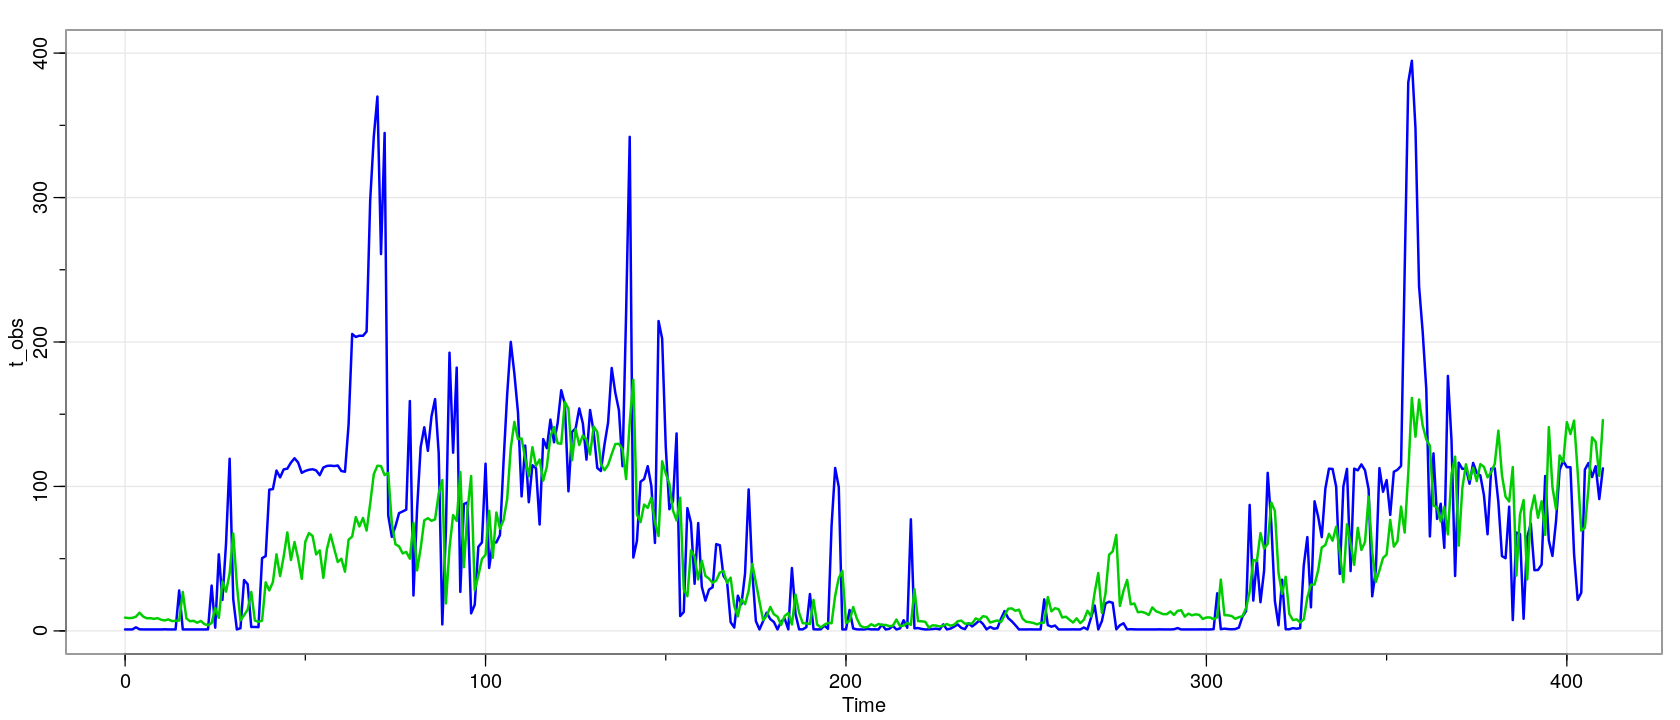

In [21]:
tsplot(t_obs, col=4, lwd=2, ylim=c(0,400))
lines(t_pred, col=3, lwd=2)